In [1]:
using Pkg
Pkg.activate(@__DIR__)

In [2]:
using AbstractGPs
using BenchmarkTools
using KernelFunctions
using LinearMixingModels
using LinearAlgebra
using Plots
using Random
using Statistics
using StatsBase;

In [3]:
using KernelFunctions: MOInputIsotopicByOutputs;

We will assume a setting similar to the defaults we see in MISO. This means 20 latent variables ($m$) with 600 outputs ($p$), ie $H \in \mathbb{R}^{600 \times 20}$, the mixing matrix, would be the first 20 Principal Components of PCA.

For the purpose of this tutorial, we will randomly generate $H$, while enforcing orthogonality in the column space, as would be the case if they were the eigenvectors of the covariance obtained via PCA. We can do this via `svd`. 

In [4]:
rng = Random.seed!(12345)
U, S, _ = svd(rand(600, 20));

An `ILMM` takes in a mixing matrix $H$ and a latent space multi-output GP, lets call it $f$. If $f$ is an `IndependentMOGP` and $H$ is `Orthogonal`, then we have an OILMM, as the orthogonality of $H$ decouples the latent processes, meaning we just have $m$ single-output GPs. We have constructors for both `Orthogonal` and `IndependentMOGP` types.

Here we build $H$ and $f$.

In [5]:
H = Orthogonal(U, Diagonal(S))
sogp = GP(Matern52Kernel())
latent_gp = independent_mogp([sogp for _ in 1:20]);

For the purpose of this demo, we will construct an equivalent `ILMM` and `OILMM` to compare performance. The only difference, given an `IndependentMOGP` latent space GP, is that the `OILMM` expects an `Orthogonal` $H$, while the `ILMM` expects a `Matrix` $H$.

In [6]:
oilmm = ILMM(latent_gp, H)
ilmm = ILMM(latent_gp, Matrix(H));

The open source GP community uses Vectors of Tuples to represent [inputs to multi output GPs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/stable/api/#Inputs-for-Multiple-Outputs). Each input is of the form `(features, output)`. As such, they can be ordered by `features` or by `outputs` using `MOInputIsotopicByFeatures` or `MOInputIsotopicByOutputs` respectively. `LinearMixingModels.jl` expects `MOInputIsotopicByOutputs`.

Note:
Heterotopic and missing data (semi-heterotopic) are not supported yet, however both cases can be addressed by [adding heterotopic support to the open source infrastructure](https://github.com/JuliaGaussianProcesses/KernelFunctions.jl/issues/358) and using the missing data techniques identified in the paper, as done in [OILMMs.jl](https://github.com/willtebbutt/OILMMs.jl/blob/master/src/missing_data.jl)

First we construct our data locations.

In [7]:
x = range(0.0, 20.0; length=576)
indices = sort(sample(1:576, 24; replace=false))
x_train = [x[i] for i in 1:576 if i ∉ indices]
x_test = [x[i] for i ∈ indices]
x_train = MOInputIsotopicByOutputs(x_train, 600)
x_test = MOInputIsotopicByOutputs(x_test, 600);

We create a finite dimensional projection at the inputs of the training dataset observed under Gaussian noise with standard deviation $\sigma$ = `1e-6`, and compute the log-likelihood of the outputs of the training dataset.

In [8]:
ilmmx = ilmm(x_train, 1e-6);

In [9]:
oilmmx = oilmm(x_train, 1e-6);

We generate our data by sampling from the prior GP.

In [10]:
y_train = rand(rng, oilmmx);

In [11]:
logpdf(ilmmx, y_train);

In [12]:
logpdf(oilmmx, y_train);

We can take a look at what our first three outputs look like.

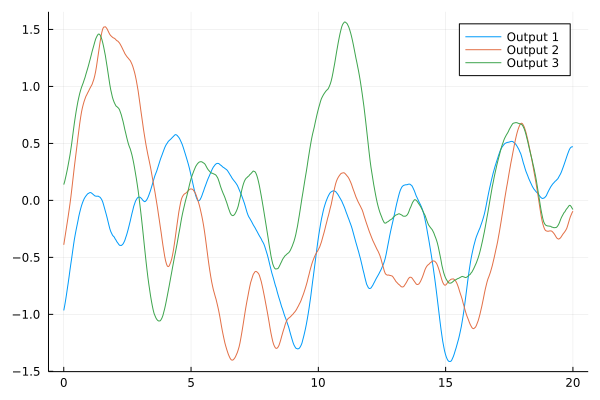

In [13]:
plot(x_train.x, y_train[1:552]; label = "Output 1")
plot!(x_train.x, y_train[553:1104]; label = "Output 2")
plot!(x_train.x, y_train[1105:1656]; label = "Output 3")

We compute the posterior Gaussian processes given the training data. Using these posteriors, which are `GPs` themselves, we can obtain a finite dimensional projection at the inputs of the test dataset. Similarily with the prior GP, we can then compute the log-likelihood of the outputs on the test dataset.

In [14]:
p_ilmmx = posterior(ilmmx, y_train);

In [15]:
p_oilmmx = posterior(oilmmx, y_train);

In [16]:
p_i = p_ilmmx(x_test, 1e-6);

In [17]:
po = p_oilmmx(x_test, 1e-6);

Again, we can see how efficient the `OILMM` is compared to the `ILMM`, while obtaining the same values.

In [18]:
marg_pi = marginals(p_i);

In [19]:
marg_po = marginals(po);

In [20]:
rand_pi = rand(rng, p_i);

In [21]:
rand_po = rand(rng, po);

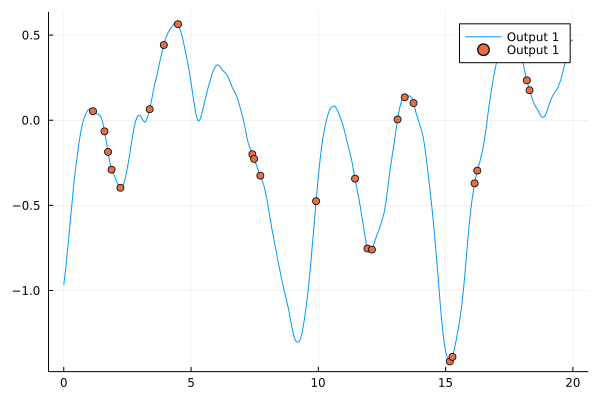

In [22]:
plot(x_train.x, y_train[1:552]; label = "Output 1")
scatter!(x_test.x, mean.(marg_po[1:24]); ribbon_scale=std.(marg_po), label = "Output 1")

# A more classic example

In [23]:
rng = Random.seed!(12345)
U, S, _ = svd(rand(3, 2));

In [24]:
H = Orthogonal(U, Diagonal(S))
gps = [GP(10, Matern52Kernel()), GP(-10, with_lengthscale(Matern32Kernel(), 0.5))]
latent_gp = independent_mogp(gps);

In [25]:
oilmm = ILMM(latent_gp, H)
ilmm = ILMM(latent_gp, Matrix(H));

In [26]:
x = range(0.0, 10.0; length=100)
indices = sort(sample(1:100, 80; replace=false))
x_train = [x[i] for i in 1:100 if i ∉ indices]
x_test = [x[i] for i in 1:100 if i ∈ indices]
x_train = MOInputIsotopicByOutputs(x_train, 3)
x_test = MOInputIsotopicByOutputs(x_test, 3);

In [27]:
oilmm = ILMM(latent_gp, H)
ilmm = ILMM(latent_gp, Matrix(H));

In [28]:
ilmmx = ilmm(x_train, 1e-6)
oilmmx = oilmm(x_train, 1e-6);

In [29]:
y_train = rand(oilmmx);

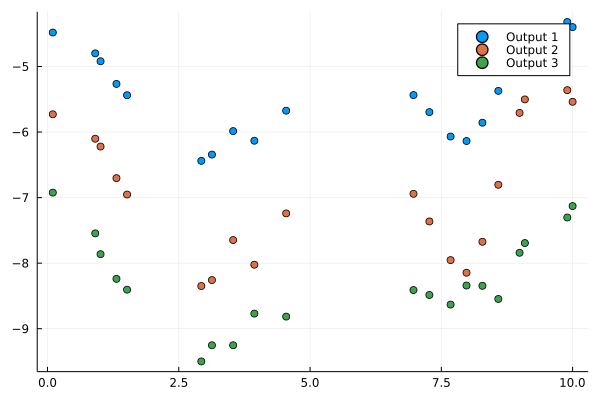

In [30]:
scatter(x_train.x, y_train[1:20]; label = "Output 1")
scatter!(x_train.x, y_train[21:40]; label = "Output 2")
scatter!(x_train.x, y_train[41:60]; label = "Output 3")

In [31]:
p_ilmmx = posterior(ilmmx, y_train)
p_oilmmx = posterior(oilmmx, y_train);

In [32]:
p_i = p_ilmmx(x_test, 1e-6)
po = p_oilmmx(x_test, 1e-6);

In [33]:
marg_pi = marginals(p_i)
marg_po = marginals(po);

In [34]:
rand_pi = rand(rng, p_i, 5)
rand_po = rand(rng, po, 5);

We can plot our predictions (means of the marginals) including our uncertainty (standard deviation of the marginals).

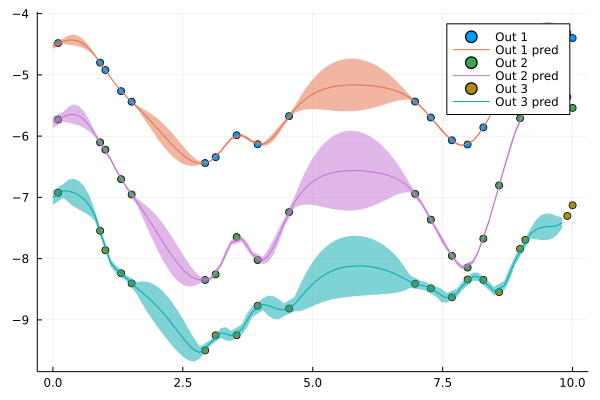

In [35]:
scatter(x_train.x, y_train[1:20]; label = "Out 1")
plot!(x_test.x, mean.(marg_pi[1:80]); ribbon=std.(marg_pi[1:80]), label = "Out 1 pred")
scatter!(x_train.x, y_train[21:40]; label = "Out 2")
plot!(x_test.x, mean.(marg_pi[81:160]); ribbon=std.(marg_pi[81:160]), label = "Out 2 pred")
scatter!(x_train.x, y_train[41:60]; label = "Out 3")
plot!(x_test.x, mean.(marg_pi[161:240]); ribbon=std.(marg_pi[161:240]), label = "Out 3 pred")

We can plot random samples from the posterior as well.

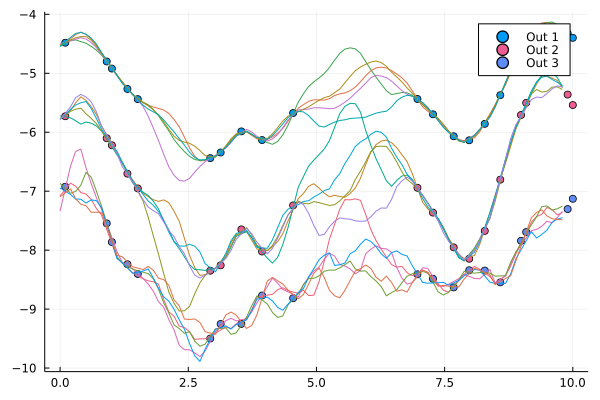

In [37]:
scatter(x_train.x, y_train[1:20]; label = "Out 1")
plot!(x_test.x, rand_po[1:80,1:5]; label = "")
scatter!(x_train.x, y_train[21:40]; label = "Out 2")
plot!(x_test.x, rand_po[81:160,1:5]; label = "")
scatter!(x_train.x, y_train[41:60]; label = "Out 3")
plot!(x_test.x, rand_po[161:240,1:5]; label = "")